The [Containers](Containers) tutorial shows examples of each of the container types in HoloViews, and it is useful to work through that before focusing on this one.  

This tutorial shows you how to combine the various container types, in order to build data structures that can contain all of the data that you want to visualize or analyze, in an extremely flexible way.  For instance, you may have a large set of measurements of different types of data (numerical, image, textual notations, etc.) from different experiments done on different days, with various different parameter values associated with each one.  HoloViews can store all of this data together, which will allow you to select just the right bit of data "on the fly" for any particular analysis or visualization, by indexing, slicing, selecting, and sampling in this data structure.

To illustrate the full functionality provided, we will create an example of the maximally nested object structure currently possible with HoloViews:

In [4]:
import numpy as np
import holoviews as hv
hv.notebook_extension()

In [7]:
np.random.seed(10)

def sine_curve(phase, freq, amp, power, samples=102):
    xvals = [0.1* i for i in range(samples)]
    return [(x, amp*np.sin(phase+freq*x)**power) for x in xvals]

phases =      [0, np.pi/2, np.pi, 3*np.pi/2]
powers =      [1,2,3]
amplitudes =  [0.5,0.75, 1.0]
frequencies = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]


gridspace = hv.GridSpace(kdims=['Amplitude', 'Power'], group='Parameters', label='Sines')

for power in powers:
    for amplitude in amplitudes:
        holomap = hv.HoloMap(kdims=['Frequency'])
        for frequency in frequencies:
            sines = {phase : hv.Curve(sine_curve(phase, frequency, amplitude, power))
                     for phase in phases}
            ndoverlay = hv.NdOverlay(sines , kdims=['Phase']).relabel(group='Phases',
                                                                      label='Sines', depth=1)
            overlay = ndoverlay * hv.Points([(i,0) for i in range(0,10)], group='Markers', label='Dots')
            holomap[frequency] = overlay
        gridspace[amplitude, power] = holomap


layout = gridspace

This code produces what looks like a relatively simple animation of two side-by-side figures, but is actually a deeply nested data structure:

:GridSpace   [Amplitude,Power]
   :HoloMap   [Frequency]
      :Overlay
         .Phases.Sines :NdOverlay   [Phase]
            :Curve   [x]   (y)
         .Markers.Dots :Points   [x,y]
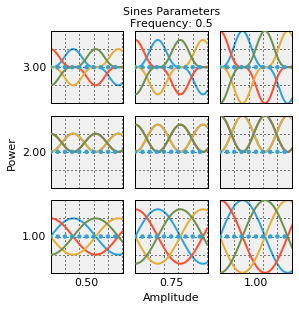
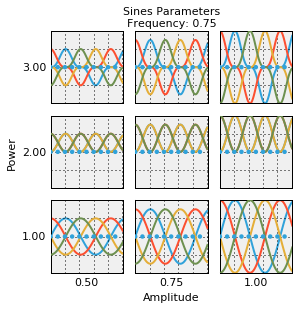
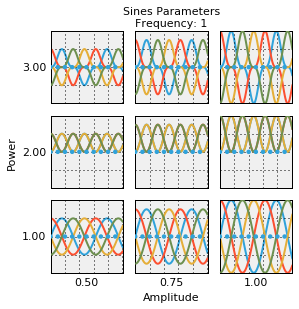
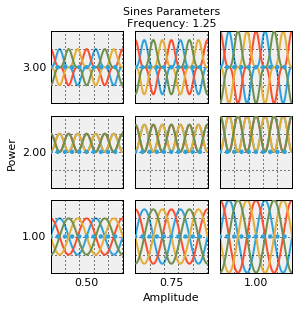
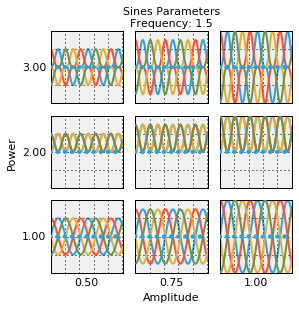
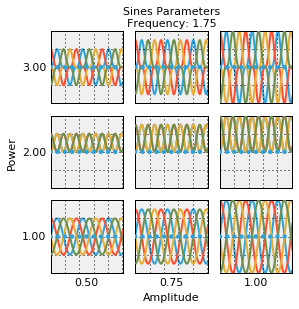

In [8]:
layout

The structure of this object can be seen in the ``repr()``:

In [ ]:
print(repr(layout))

## Nesting hierarchy <a id='NestingHierarchy'></a>

To help us understand this structure, here is a schematic for us to refer to as we unpack this object, level by level:

<center><img src="https://ioam.github.io/holoviews/Tutorials/nesting-diagram.png"></center>

Everything that is *displayable* in HoloViews has this same basic structure, although any of the levels can be omitted in simpler cases, and many different Element types (not containers) can be substituted for any other.  

Since HoloViews 1.3.0 you are allowed to build data-structures that violate this hierarchy (e.g you can put ``Layout`` objects into ``HoloMaps``) but the resulting object cannot be displayed. Instead, you will be prompted with a message to call the ``collate`` method. Using the ``collate`` method will allow you to generate the appropriate object that correctly obeys the hierarchy shown above.

As shown in the diagram, there are three different types of container involved:

- Basic Element: elementary HoloViews object containing raw data, typically a Numpy array.
- Homogenous container (UniformNdMapping): collections of Elements or other HoloViews components that are all the same type.  These are indexed using array-style key access with values sorted along some dimension(s), e.g. ``[0.50]`` or ``["a",7.6]``.
- Heterogenous container (AttrTree): collections of data of different types, e.g. different types of Element.  These are accessed by categories using attributes, e.g. ``.Parameters.Sines``, which does not assume any ordering of a dimension

We will now go through each of the containers of these different types, at each level.

### ``Layout`` Level

Above, we have already viewed the highest level of our data structure as a layout. Here is the repr of entire layout object which reflects all the levels shown in the diagram:

In [ ]:
print(repr(layout))

### ``GridSpace`` Level

As shown in the [Introductory tutorial](Introduction), elements of a ``Layout``, such as the ``GridSpace`` in this example, are reached via attribute access:

In [ ]:
layout.Parameters.Sines

### ``HoloMap`` Level

This ``GridSpace`` consists of nine ``HoloMap``s arranged in a two-dimensional space.  Let's now select one of these ``HoloMap`` objects, the one at [Amplitude,Power] ``[0.5,1.0]``, i.e. the lowest amplitude and power:

In [ ]:
layout.Parameters.Sines[0.5, 1]

As shown in the schematic above, a ``HoloMap`` contains many elements with associated keys. In this example, these keys are indexed with a dimension ``Frequency``, which is why the ``Frequency`` varies when you play the animation here.

### ``Overlay`` Level

The ``repr()`` showed us that the ``HoloMap`` is composed of ``Overlay`` objects, six in this case (giving six frames to the animation above).  Let us access one of these elements, i.e. one frame of the animation above, an ``Overlay`` associated with the key with a ``Frequency`` of *1.0*:

In [ ]:
layout.Parameters.Sines[0.5, 1][1.0]

### NdOverlay Level

As the ``repr()`` shows, the ``Overlay`` contains a ``Points`` object and an ``NdOverlay`` object.  We can access either one of these using the attribute access supported by ``Overlay``:

In [ ]:
(layout.Parameters.Sines[0.5, 1][1].Phases.Sines +
 layout.Parameters.Sines[0.5, 1][1].Markers.Dots)

### ``Curve`` Level

The ``NdOverlay`` is so named because it is an overlay of items indexed by dimensions, unlike the regular attribute-access overlay types.  In this case it is indexed by ``Phase``, with four values.  If we select one of these values, we will get an individual ``Curve``, e.g. the one with zero phase:

In [ ]:
l=layout.Parameters.Sines[0.5, 1][1].Phases.Sines[0.0]
l

In [ ]:
repr(l)

### Data Level

At this point, we have reached the end of the HoloViews objects; below this object is only the raw data as a Numpy array:

In [ ]:
type(layout.Parameters.Sines[0.5, 1][1].Phases.Sines[0.0].data)

Of course, you can keep going down into the Numpy array as far as it goes, to get down to a single datapoint, in this case the value at x=5.2. Note that the supplied index has to match the x-value of the underlying data exactly to floating point precision, so only use this if you know exactly what you are doing:

In [ ]:
layout.Parameters.Sines[0.5, 1][1].Phases.Sines[0.0][5.2]

Here the value returned is the y-value of the underlying data, at last!  Of course, you can also use all of the access methods provided by the numpy array itself, using ``.data``, e.g. ``.data[52]``, but note that this will use the native indexing scheme of the array, i.e. integer access, starting at zero, not the [continuous coordinate system](Continuous_Coordinates) we provide through HoloViews.

### Indexing using ``.select``

The curve displayed immediately above shows the final, deepest access possible in HoloViews for this object.

```python
layout.Parameters.Sines[0.5, 1][1].Phases.Sines[0.0]
```
This is the curve with an amplitude of *0.5*, raised to a power of *1.0* with frequency of *1.0* and *0* phase. These are all the numbers, in order, used in the access shown above.

The ``.select`` method is a more explicit way to use key access, with both of these equivalent to each other:

In [ ]:
o1 = layout.Parameters.Sines.select(Amplitude=0.5, Power=1.0).select(Frequency=1.0)
o2 = layout.Parameters.Sines.select(Amplitude=0.5, Power=1.0, Frequency=1.0)
o1 + o2

The second form demonstrates HoloViews' **deep indexing** feature. This is as far as we can index before reaching a heterogeneous type (the ``Overlay``), where we need to use attribute access. Here is the more explicit method of indexing down to a curve:

In [ ]:
layout.Parameters.Sines.select(Amplitude=0.5,Power=1.0, 
                               Frequency=1.0).Phases.Sines.select(Phase=0.0)

## Summary

As you can see, HoloViews lets you compose objects of heterogenous types, and objects covering many different numerical or other dimensions, laying them out spatially or as overlays where appropriate.  The resulting data structures are complex, but they are composed of simple elements with well-defined interactions, making it feasible to express nearly any relationship that will characterize your data.  In practice, you will probably not need this many levels, but given this complete example, you should be able to construct an appropriate organization for whatever type of data that you do want to organize or visualize. 

As emphasized above, it is not possible to combine these objects in other orderings.  Of course, any ``Element`` can be substituted for any other, which doesn't change the structure.  But you cannot e.g. have an ``Overlay`` or ``HoloMap`` of ``Layout`` objects.  Confusingly, the objects may *act* as if you have these arrangements.  For instance, a ``Layout`` of ``HoloMap`` objects will be animated, like ``HoloMap`` objects, but only because of the extra dimension(s) provided by the enclosed ``HoloMap`` objects, not because the ``Layout`` itself has data along those dimensions.  Similarly, you cannot have a ``Layout`` of ``Layout`` objects, even though it looks like you can.  E.g. the ``+`` operator on two ``Layout`` objects will not create a ``Layout`` of ``Layout`` objects; it just creates a new ``Layout`` object containing the data from both of the other objects.  Similarly for the ``Overlay`` of ``Overlay`` objects using ``*``; only a single combined ``Overlay`` is returned.

If you are confused about how all of this works in practice, you can use the examples in the tutorials to guide you, especially the [Exploring Data](Exploring_Data) tutorial.  